### Load libraries

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import timeit
from time import time
import pandas as pd
import random

from scipy.optimize import curve_fit
from tabulate import tabulate
from scipy import optimize

### Load Data

In [3]:
random.seed(10)

df = pd.read_excel(r'April112019.xlsx', sheet_name='Data', index_col = 0)
df.head()

,43602,43603,43604,43605,43606,43607,43608,43609,43610,43611,43612,43613,43614,43615,43616,43617,43618,43619
ATM,0.115736,0.128755,0.133229,0.136649,0.138610,0.143332,0.145744,0.149926,0.156189,0.162946,0.165823,0.175587,0.185134,0.194641,0.204257,0.214142,0.224589,0.230527
t,27.000000,51.000000,70.000000,90.000000,114.000000,176.000000,236.000000,300.000000,425.000000,547.000000,672.000000,921.000000,1170.000000,1424.000000,1673.000000,1922.000000,2171.000000,2420.000000
f,3424.623364,3424.922072,3425.158183,3425.380282,3425.657945,3426.339971,3426.941883,3427.506049,3429.085029,3431.578705,3435.536865,3376.692495,3283.969951,3202.463380,3130.812524,3068.428414,3014.984454,2967.665862
K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,1.903188,1.501759,1.336821,1.226647,1.126206,0.967003,0.870862,0.805238,0.722324,0.667725,0.626861,0.573689,0.539000,0.514056,0.496268,0.483033,0.473398,0.461672


### Calibration

In [4]:
#assumptions and datas
#set the beta equal to one
beta = 1 

# Time to Exercise(tau) in years , from 11 April
t_exp = df.iloc[1,:].to_numpy()/253

# Forwards (f) array
f = df.iloc[2,:].to_numpy()

# strike prices
strikes = df.index[4:].to_numpy()

# At the money sigmas
atm_sigma = df.iloc[0,:].to_numpy()

#observed sigmas of market
sigmas = df.iloc[4:,:].to_numpy()


In [5]:
t_exp

array([0.10671937, 0.20158103, 0.27667984, 0.35573123, 0.45059289,
       0.69565217, 0.93280632, 1.18577075, 1.6798419 , 2.16205534,
       2.65612648, 3.64031621, 4.62450593, 5.6284585 , 6.61264822,
       7.59683794, 8.58102767, 9.56521739])

In [6]:
#implied volatility based on Hagan paper
def SABR_market_vol(K,f,t_exp,sigma0,beta,alpha,rho):
    output = np.zeros(len(K))
    for i in range(0,len(K)):
        if K[i] == f: #ATM equation in Managing smile risk
                part_1 = (1.0 - beta)**2.0*sigma0**2.0/(24.0*f**(2.0 - 2.0*beta))
                part_2 = rho*beta*sigma0*alpha/(4.0*f**(1.0 - beta))
                part_3 = (2.0 - 3.0*rho**2)*alpha**2.0/24.0
            
                output[i] = (sigma0/f**(1 - beta))*(1 + (part_1 + part_2 + part_3)*t_exp )
        
        else:
                logfK = np.log(f/K[i])
                fkbpow = (f*K[i])**((1.0 - beta)/2.0)
                z = alpha*fkbpow*logfK/sigma0
                xz = np.log((np.sqrt(1.0 - 2.0*rho*z + z**2.0 ) + z - rho)/(1.0-rho))
            
                part_1 = ((1.0-beta)**2.0)*(sigma0**2.0)/(24.0*fkbpow**2.0)
                part_2 = (rho*beta*alpha*sigma0)/(4.0*fkbpow)
                part_3 = (2.0-3.0*rho**2)*alpha**2.0/24.0
                part_4 = ((1.0-beta)**2)*(logfK**2)/24.0
                part_5 = ((1.0-beta)**4)*(logfK**4)/1920.0
            
                output[i] = (sigma0*z*(1 + (part_1 + part_2 + part_3)*t_exp))/(fkbpow*xz*(1 + part_4 + part_5 ))
    return output

def atm_sigma_to_sigma0(f,t_exp,sigma_atm,beta,alpha,rho):
    
    #The coeffceints of the polynomial we find the roots of
    p_3 = -sigma_atm
    p_2 =  (1 + (2-3*rho**2)*alpha**2*t_exp/24)/f**(1.-beta)
    p_1 = rho*beta*alpha*t_exp/(4*f**(2-2*beta))
    p_0 = (1-beta)**2*t_exp/(24*f**(3-3*beta))
    coeffs = [p_0,p_1,p_2,p_3]
    
    r = np.roots(coeffs)    #find the roots of the cubic equation
    
    return r[(r.imag==0) & (r.real>=0)].real.min()

def SABR_calibration(f, t_exp, sigma_atm, beta, strikes, vols,guess):
    
    def func_to_optimize(K,alpha,rho):
        sigma0 = atm_sigma_to_sigma0(f,t_exp,sigma_atm,beta,alpha,rho)
        return  SABR_market_vol(K,f,t_exp,sigma0,beta,alpha,rho)
    popt, pcov = curve_fit(func_to_optimize, strikes, vols, p0 = (guess[1],guess[2]), maxfev=10000)
      
    alpha = popt[0]
    rho = popt[1]
    sigma0 = atm_sigma_to_sigma0(f,t_exp,sigma_atm,beta,alpha,rho)
    
    return [sigma0, alpha, rho]

In [7]:
alpha = np.zeros(18)
rho= np.zeros(18)
sigma0 = np.zeros(18)

for j in range(0,18):

    guess = [0.01, 10,-0.6]
    anr= SABR_calibration(f[j], t_exp[j], atm_sigma[j] , 1, strikes, sigmas[:,j],guess)
    sigma0[j]=anr[0]
    alpha[j]= anr[1]
    rho[j]=anr[2]
    
table = pd.DataFrame( [["Coefficient/Date","5/17/2019","6/21/2019","7/19/2019","8/16/2019","9/20/2019","12/20/2019","3/20/2020","6/19/2020","12/18/2020","6/18/2021","12/17/2021","12/16/2022","12/15/2023","12/20/2024","12/19/2025","12/18/2026","12/17/2027","12/15/2028"
],
["sigma0" , sigma0[0], sigma0[1],sigma0[2],sigma0[3],sigma0[4],sigma0[5],sigma0[6],sigma0[7],sigma0[8],sigma0[9],sigma0[10],sigma0[11],sigma0[12],sigma0[13],sigma0[14],sigma0[15],sigma0[16],sigma0[17]],
["alpha", alpha[0],alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],alpha[6],alpha[7],alpha[8],alpha[9],alpha[10],alpha[11],alpha[12],alpha[13],alpha[14],alpha[15],alpha[16],alpha[17]],
["rho",  rho[0],rho[1],rho[2],rho[3],rho[4],rho[5],rho[6],rho[7],rho[8],rho[9],rho[10],rho[11],rho[12],rho[13],rho[14],rho[15],rho[16],rho[17]]
])
table   

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Coefficient/Date,5/17/2019,6/21/2019,7/19/2019,8/16/2019,9/20/2019,12/20/2019,3/20/2020,6/19/2020,12/18/2020,6/18/2021,12/17/2021,12/16/2022,12/15/2023,12/20/2024,12/19/2025,12/18/2026,12/17/2027,12/15/2028
1,sigma0,0.113589,0.126545,0.131194,0.134733,0.136896,0.141967,0.144682,0.148667,0.155499,0.162366,0.165643,0.176258,0.186826,0.197236,0.20765,0.218243,0.22932,0.235233
2,alpha,2.392842,1.70887,1.449605,1.280838,1.135271,0.908927,0.779392,0.687932,0.575627,0.500328,0.450036,0.380794,0.335761,0.302432,0.277083,0.256571,0.239466,0.225291
3,rho,-0.601772,-0.58535,-0.588764,-0.58963,-0.592674,-0.590282,-0.587344,-0.553762,-0.551978,-0.523538,-0.518493,-0.505953,-0.49965,-0.48643,-0.469492,-0.449706,-0.427692,-0.400339


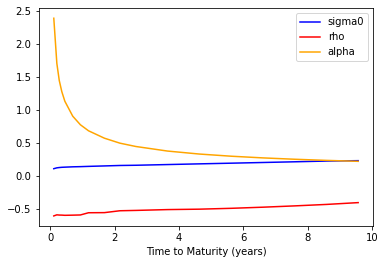

In [8]:
plt.plot(t_exp,sigma0, color='blue',label='sigma0')
plt.plot(t_exp,rho,color='red',label='rho')
plt.plot(t_exp,alpha, color='orange',label='alpha')
plt.xlabel("Time to Maturity (years)")
plt.show
plt.legend()
plt.savefig('param_calib')

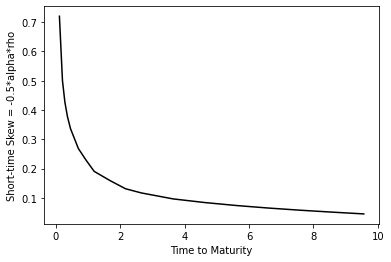

In [9]:
stskew=-0.5*rho*alpha

plt.plot(t_exp,stskew, color='black')
plt.ylabel("Short-time Skew = -0.5*alpha*rho")
plt.xlabel("Time to Maturity")
plt.show
plt.savefig('stskew')

### Monte Carlo simulation

In [10]:
Norm = ss.norm.cdf
def BlackScholes(F0, K, r, sigma, T):
    d1 = (np.log(F0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (F0*Norm(d1) - K*Norm(d2)*np.exp(-r*T))

def get_increments(T, N, reverse = False):
  incr = np.linspace(0,T+T/N,N)
  return np.flip(incr) if (reverse) else incr

def get_brownian(T, N, n, Br = None):
  size = (n, N)
  Z = Br if Br is not None else np.random.normal(0, 1, size)
  Z[:, 0] = 0
  W = np.cumsum(Z * np.sqrt(T/N), 1)
  return (W, Z)

def get_sigmas(T, N, n, Brownian, init, alpha):
  sigma = init * np.exp(-(alpha**2)/2*np.concatenate([[get_increments(T, N)]] * n)) * np.exp(alpha*Brownian)
  sigma = np.insert(sigma, 0, init, axis=1)
  return np.delete(sigma, -1, axis=1)

def CMC(T,r,F0,K,alpha,sigma0,rho, n, N, Br = None):
    (W, Z) = get_brownian(T, N, n, Br)
    sigma=get_sigmas(T, N, n, W, sigma0, alpha)
    sigma_bar=np.sqrt((1-rho**2)*np.sum(sigma**2, axis = 1)/N)
    var=np.sum(sigma**2*T/N, axis = 1)
    var2=np.sum(sigma*Z*np.sqrt(T/N), axis = 1)
    F01=F0*np.exp(-0.5*rho**2*var+rho*var2)
    BS1=BlackScholes(F01, K, r, sigma_bar, T)
    BSPrice=np.mean(BS1)
    return BSPrice




### Monte Carlo simulation for one set of parameters to test the time of calculation

In [11]:
def counter():
    n_list = [100, 1000, 10000]
    mean = []
    stand = []
    timer = []
    for n in n_list:
        (T, r, F0, K, alpha, sigma0, rho, N) = (1, 0, 100, 100, 0.5, 0.3, -0.5, 1000)
        start = timeit.default_timer()
        simulacio = np.zeros(10)
        for i in range(0,10):
            simulacio[i]=CMC(T, r, F0, K, alpha, sigma0, rho, n, N)
        mean.append(np.mean(simulacio))
        stand.append(np.std(simulacio))
        stop = timeit.default_timer()
        timer.append(stop - start)
    return (mean, stand, timer)

(mean, stand, timer) = counter()

table = [["Method","Time Steps m","No. of simulation trials","Time (Seconds)","Mean","stdev"],
["CMC", "1000", "100", timer[0], mean[0], stand[0]],
["CMC", "1000", "5000", timer[1], mean[1], stand[1]],
["CMC", "1000", "10000", timer[2], mean[2], stand[2]]
]
print(tabulate(table, tablefmt='fancy_grid'))


╒════════╤══════════════╤══════════════════════════╤═════════════════════╤════════════════════╤═════════════════════╕
│ Method │ Time Steps m │ No. of simulation trials │ Time (Seconds)      │ Mean               │ stdev               │
├────────┼──────────────┼──────────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ CMC    │ 1000         │ 100                      │ 0.05967349999991711 │ 11.895060445325107 │ 0.5215523616473055  │
├────────┼──────────────┼──────────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ CMC    │ 1000         │ 5000                     │ 0.8748406000004252  │ 11.869718572030242 │ 0.2132503147705334  │
├────────┼──────────────┼──────────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ CMC    │ 1000         │ 10000                    │ 8.885752000000139   │ 11.828896793487553 │ 0.05839942108180633 │
╘════════╧══════════════╧══════════════════════════╧════

In [12]:
def ImpliedBrent(F0,K,r,T,OptionPrice):
    
    def f(I0):
        f=(BlackScholes(F0,K,r,I0,T)-OptionPrice)**2
        return(f) 
    I = optimize.minimize_scalar(f,bounds=(0.001,5),method="bounded")
    return(I)

### Calculating volatilities with calibrated Coefficients and CMC 

In [30]:
# Assumptions
n = 5000
N = 1000
r = 0.005
beta=1
f0 = f[8]
atm=strikes/f0


In [31]:
prices_CMC = np.zeros([51,18])
sigmas_CMC = np.zeros([51,18])
sigmas_Hagen = np.zeros([51,18])
sigmas_Hagen_const = np.zeros([51,18])

L = np.random.normal(0,1,[n,N])

start = time()
for j in range(len(t_exp)):
    for i in range(len(strikes)):
        prices_CMC[i,j] = CMC(t_exp[j], r, f[j] ,strikes[i], alpha[j], sigma0[j], rho[j] , n, N,L)
        sigmas_CMC[i,j] = ImpliedBrent(f[j], strikes[i], r, t_exp[j] , prices_CMC[i,j])["x"]
end = time() 
t1 = (end - start)        
        
start =time()
for j in range(len(t_exp)):
    for i in range(len(strikes)):
        sigmas_Hagen[i,j] = SABR_market_vol(strikes,f[j],t_exp[j],sigma0[j],beta,alpha[j],rho[j])[i]
end = time() 
t2 = (end - start)        

start=time()
for i in range(len(strikes)):
    for j in range(len(t_exp)):
        sigmas_Hagen_const[i,j] = SABR_market_vol(strikes,f[5],t_exp[j],sigma0[5],beta,alpha[5],rho[5])[i]
end=time()        
t3 = (end - start)        

table = [["Method","Time (Seconds)"],
["CMC", round(t1,5)],        
["Hagen",  round(t2,5)],
["Hagen constant",round(t3,5)]         
]        

print(tabulate(table, tablefmt='fancy_grid'))




╒════════════════╤════════════════╕
│ Method         │ Time (Seconds) │
├────────────────┼────────────────┤
│ CMC            │ 305.8484       │
├────────────────┼────────────────┤
│ Hagen          │ 0.59785        │
├────────────────┼────────────────┤
│ Hagen constant │ 0.57776        │
╘════════════════╧════════════════╛


### Plots

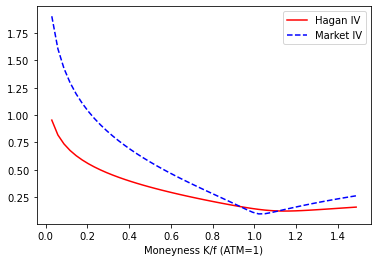

In [32]:
# Draw Smile for a single maturity with one set of coefs using Hagen

plt.plot(atm,sigmas_Hagen_const[:,0],color= 'red',label='Hagan IV')
plt.plot(atm,sigmas[:,0],'b--',label='Market IV')
plt.xlabel('Moneyness K/f (ATM=1)')
plt.show
plt.legend()
#plt.savefig('smile_hagan1')

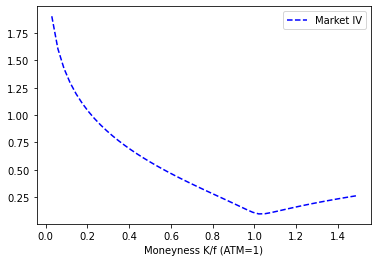

In [51]:
plt.plot(atm,sigmas[:,0],'b--',label='Market IV')
plt.xlabel('Moneyness K/f (ATM=1)')
plt.show
plt.legend()

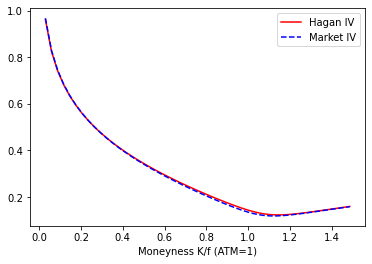

In [33]:
# Draw Smile for a single maturity with different set of coefs using Hagen

plt.plot(atm,sigmas_Hagen[:,5],color= 'red',label='Hagan IV')
plt.plot(atm,sigmas[:,5],'b--',label='Market IV')
plt.xlabel('Moneyness K/f (ATM=1)')
plt.show
plt.legend()
#plt.savefig('smile_hagan')

In [58]:
t_exp

array([0.10671937, 0.20158103, 0.27667984, 0.35573123, 0.45059289,
       0.69565217, 0.93280632, 1.18577075, 1.6798419 , 2.16205534,
       2.65612648, 3.64031621, 4.62450593, 5.6284585 , 6.61264822,
       7.59683794, 8.58102767, 9.56521739])

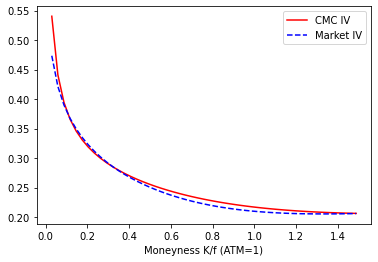

In [61]:
# Draw Smile for a single maturity with different set of coefs using CMC

plt.plot(atm,sigmas_CMC[:,16],color= 'red',label='CMC IV')
plt.plot(atm,sigmas[:,16],'b--',label='Market IV')
plt.xlabel('Moneyness K/f (ATM=1)')
plt.show
plt.legend()
#plt.savefig('smile_CMC')

### Mean Squared Errors (MSE)

In [35]:
square_error=np.zeros([51,18])
for j in range(0,len(t_exp)):
    for i in range(0,len(strikes)):
        square_error[i,j] = (sigmas[i,j]-sigmas_Hagen_const[i,j])**2
        

In [36]:
# Using a single set of parameters for all maturities
square_error=np.zeros([51,18])
for j in range(0,len(t_exp)):
    for i in range(0,len(strikes)):
        square_error[i,j] = (sigmas[i,j]-sigmas_Hagen_const[i,j])**2
        
sse1=sum(square_error)
sse_hagan=sum(sse1)
M=len(strikes)*len(t_exp)
mse_hagan=sse_hagan/M


# MSE by Maturity
mse_T=np.zeros(len(t_exp))
for i in range(0,len(t_exp)):
    mse_T[i]=sum(square_error[:,i])/len(strikes)
    
    
# MSE by Strike
mse_K=np.zeros(len(strikes))
for i in range(0,len(strikes)):
    mse_K[i]=sum(square_error[i,:])/len(t_exp)
    

In [37]:
# Using different parameters for each maturity

square_error=np.zeros([51,18])
for j in range(0,len(t_exp)):
    for i in range(0,len(strikes)):
        square_error[i,j] = (sigmas[i,j]-sigmas_Hagen[i,j])**2
        
sse2=sum(square_error)
sse2_hagan=sum(sse2)
M=len(strikes)*len(t_exp)
mse2_hagan=sse2_hagan/M

# MSE by Maturity
mse2_T=np.zeros(len(t_exp))
for i in range(0,len(t_exp)):
    mse2_T[i]=sum(square_error[:,i])/len(strikes)
    
    
# MSE by Strike
mse2_K=np.zeros(len(strikes))
for i in range(0,len(strikes)):
    mse2_K[i]=sum(square_error[i,:])/len(t_exp)  

In [38]:
# using CMC 

square_error=np.zeros([51,18])
for j in range(0,len(t_exp)):
    for i in range(0,len(strikes)):
        square_error[i,j] = (sigmas[i,j]-sigmas_CMC[i,j])**2
sse3=sum(square_error)
sse3_CMC=sum(sse3)
M=len(strikes)*len(t_exp)
mse3_CMC=sse3_CMC/M

# MSE by Maturity
mse3_T=np.zeros(len(t_exp))
for i in range(0,len(t_exp)):
    mse3_T[i]=sum(square_error[:,i])/len(strikes)
# MSE by Strike
mse3_K=np.zeros(len(strikes))
for i in range(0,len(strikes)):
    mse3_K[i]=sum(square_error[i,:])/len(t_exp)

In [39]:
# using CMC 

square_error=np.zeros([51,18])
for j in range(0,len(t_exp)):
    for i in range(0,len(strikes)):
        square_error[i,j] = (sigmas[i,j]-sigmas_CMC[i,j])**2
sse4=sum(square_error)
sse4_CMC=sum(sse4)
M=len(strikes)*len(t_exp)
mse4_CMC=sse4_CMC/M

# MSE by Maturity
mse4_T=np.zeros(len(t_exp))
for i in range(0,len(t_exp)):
    mse4_T[i]=sum(square_error[:,i])/len(strikes)
# MSE by Strike
mse4_K=np.zeros(len(strikes))
for i in range(0,len(strikes)):
    mse4_K[i]=sum(square_error[i,:])/len(t_exp)

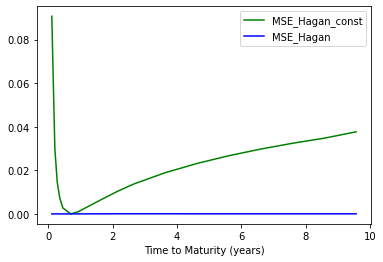

In [40]:
plt.plot(t_exp,mse_T,label="MSE_Hagan_const", color='green')
plt.plot(t_exp,mse2_T,label="MSE_Hagan", color ='blue')
plt.xlabel("Time to Maturity (years)")
plt.show
plt.legend()
plt.savefig('mse_T_hagan')

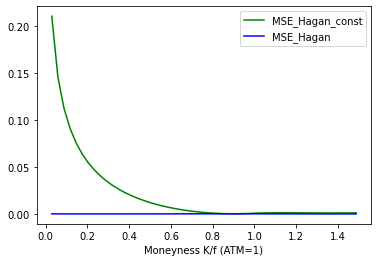

In [41]:
plt.plot(atm,mse_K,label="MSE_Hagan_const", color='green')
plt.plot(atm,mse2_K,label="MSE_Hagan", color='blue')
plt.xlabel("Moneyness K/f (ATM=1)")
plt.show
plt.legend()
plt.savefig('mse_K_hagan')

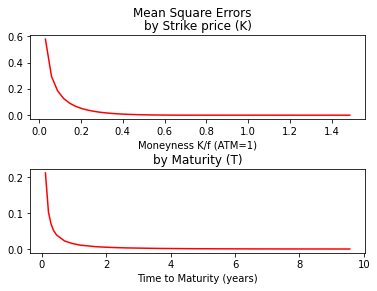

In [42]:
# Only CMC errors
plt.subplot(2,1,1)    
plt.plot(atm,mse3_K,label="MSE_CMC",color='red')
plt.title('by Strike price (K)')
plt.xlabel("Moneyness K/f (ATM=1)")

plt.subplot(2,1,2)    
plt.plot(t_exp,mse3_T,label="MSE_CMC", color='red')
plt.xlabel("Time to Maturity (years)")
plt.title('by Maturity (T)')

plt.suptitle('Mean Square Errors')
plt.subplots_adjust(hspace=0.6)#,left=0, bottom=0, right=1, top=1, wspace=0.1, )

plt.show()

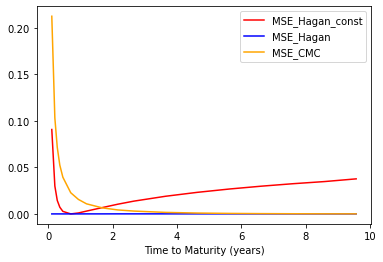

In [43]:
# MEAN SQUARE ERRORS BY Maturity

plt.plot(t_exp,mse_T, label="MSE_Hagan_const", color='red')
plt.plot(t_exp,mse2_T,label="MSE_Hagan", color='blue')
plt.plot(t_exp,mse3_T,label="MSE_CMC", color='orange')
plt.xlabel("Time to Maturity (years)")
plt.show
plt.legend()
#plt.savefig('mse_T_hagan-CMC1')

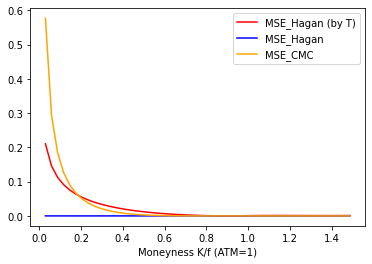

In [44]:
# MEAN SQUARE ERRORS BY STRIKE PRICE
plt.plot(atm,mse_K,label="MSE_Hagan (by T)",color='red')
plt.plot(atm,mse2_K,label="MSE_Hagan",color='blue')
plt.plot(atm,mse3_K,label="MSE_CMC",color='orange')
plt.xlabel("Moneyness K/f (ATM=1)")
plt.show
plt.legend()
plt.savefig('mse_K_hagan-CMC1')

In [45]:
table = [["Method","Time (Seconds)","MSE (%)"],
["CMC", round(t1,5),round(mse3_CMC*100,3)],      
["Hagen",  round(t2,5),round(mse2_hagan*100,3)],
["Hagen_const",round(t3,5),round(mse_hagan*100,3)]         
] 
print(tabulate(table, tablefmt='fancy_grid'))


╒═════════════╤════════════════╤═════════╕
│ Method      │ Time (Seconds) │ MSE (%) │
├─────────────┼────────────────┼─────────┤
│ CMC         │ 305.8484       │ 3.035   │
├─────────────┼────────────────┼─────────┤
│ Hagen       │ 0.59785        │ 0.005   │
├─────────────┼────────────────┼─────────┤
│ Hagen_const │ 0.57776        │ 2.134   │
╘═════════════╧════════════════╧═════════╛


### Volatility Surface

In [ ]:
# initiate figure
fig = plt.figure(figsize=(7,7))
# set projection to 3d
axs = plt.axes(projection="3d")
axs.plot_surface(X,Y, ov,color='blue')
# change angle
axs.view_init(20, 70)
# add labels
plt.xlabel('Strike Price')
plt.ylabel('Maturity')
plt.title("Blue = Market Data   Red =Hagan with constant coefs ")
plt.show()

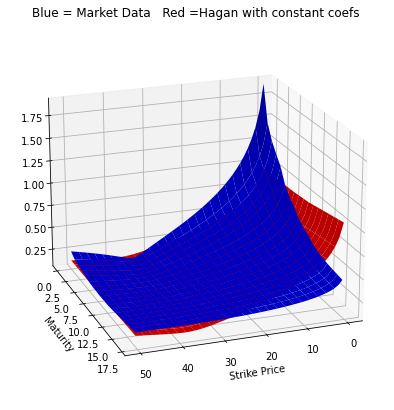

In [46]:
# Volatility Surface of Hagan with constant coefs and Market Data")
T= np.arange (0, 51, 1) 
K= np.arange (0, 18, 1)

def impliedvolatility_fixed(T,K):
    return sigmas_Hagen_const[T][K]
def observed_volatilility(T,K):
    return sigmas[T][K]
impliedvol=np.vectorize(impliedvolatility_fixed)
observol=np.vectorize(observed_volatilility)
X, Y = np.meshgrid(T,K)
iv = impliedvol(X,Y)
ov= observol(X,Y)
# initiate figure
fig = plt.figure(figsize=(7,7))
# set projection to 3d
axs = plt.axes(projection="3d")
axs.plot_surface(X,Y, ov,color='blue')
axs.plot_surface(X,Y, iv, color='red')
# change angle
axs.view_init(20, 70)
# add labels
plt.xlabel('Strike Price')
plt.ylabel('Maturity')
plt.title("Blue = Market Data   Red =Hagan with constant coefs ")
plt.show()

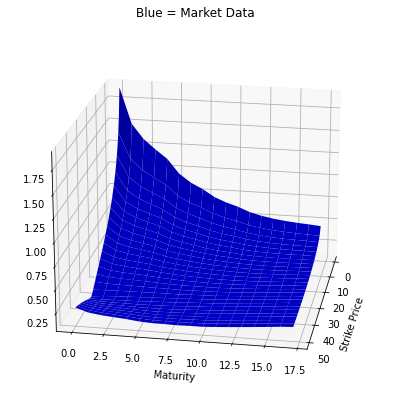

In [53]:
# initiate figure
fig = plt.figure(figsize=(7,7))
# set projection to 3d
axs = plt.axes(projection="3d")
axs.plot_surface(X,Y, ov,color='blue')
# change angle
axs.view_init(20, 10)
# add labels
plt.xlabel('Strike Price')
plt.ylabel('Maturity')
plt.title("Blue = Market Data ")
plt.show()

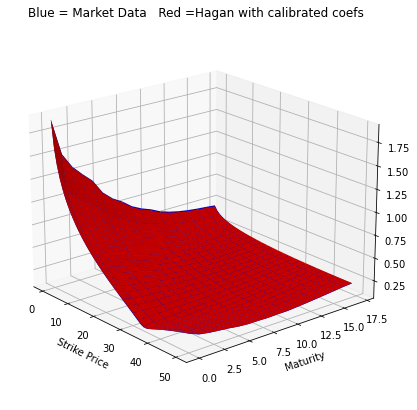

In [57]:
# Volatility Surface of Hagan with calibrated coefs and Market Data")
T= np.arange (0, 51, 1) 
K= np.arange (0, 18, 1)

def impliedvolatility_fixed(T,K):
    return sigmas_Hagen[T][K]
def observed_volatilility(T,K):
    return sigmas[T][K]
impliedvol=np.vectorize(impliedvolatility_fixed)
observol=np.vectorize(observed_volatilility)
X, Y = np.meshgrid(T,K)
iv = impliedvol(X,Y)
ov= observol(X,Y)
# initiate figure
fig = plt.figure(figsize=(7,7))
# set projection to 3d
axs = plt.axes(projection="3d")
axs.plot_surface(X,Y, ov,color='blue')
axs.plot_surface(X,Y, iv, color='red')
# change angle
axs.view_init(20, -40)
# add labels
plt.xlabel('Strike Price')
plt.ylabel('Maturity')
plt.title("Blue = Market Data   Red =Hagan with calibrated coefs ")
plt.show()

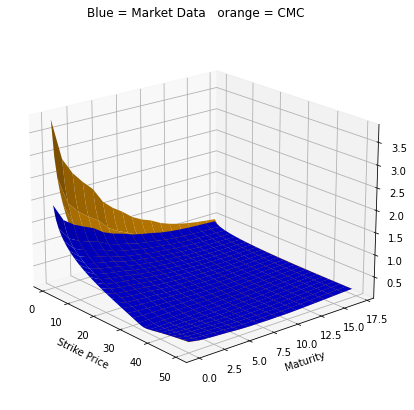

In [48]:
# Volatility Surface of CMC and Market Data")
T= np.arange (0, 51, 1) 
K= np.arange (0, 18, 1)

def impliedvolatility_fixed(T,K):
    return sigmas_CMC[T][K]
def observed_volatilility(T,K):
    return sigmas[T][K]
impliedvol=np.vectorize(impliedvolatility_fixed)
observol=np.vectorize(observed_volatilility)
X, Y = np.meshgrid(T,K)
iv = impliedvol(X,Y)
ov= observol(X,Y)
# initiate figure
fig = plt.figure(figsize=(7,7))
# set projection to 3d
axs = plt.axes(projection="3d")
axs.plot_surface(X,Y, ov,color='blue')
axs.plot_surface(X,Y, iv, color='orange')
# change angle
axs.view_init(20,-40 )
# add labels
plt.xlabel('Strike Price')
plt.ylabel('Maturity')
plt.title("Blue = Market Data   orange = CMC ")
plt.show()